# * Preprocessing*

In [34]:
# Import datadriven feature selection set by technique LASSO
# load the featureset file
import pandas as pd
df=pd.read_csv(r'C:\Users\u1246538\Downloads\liss-data\Notebooks_MHI-5\selected_features_rf_with_id.csv')
df.head()

,nomem_encr,emotional_stability,self_esteem,Self-Rated_Health,age,Health_Hindrance_to_Daily_Functioning,nomem_encr.1,Sleeping_Problems,conscientiousness,composite_values,intellect_imagination
0,800015,4.3,6.2,3,60.0,1.0,800015,0.0,4.4,5.750000,3.9
1,800100,2.7,5.2,2,32.0,3.0,800100,0.0,4.4,6.500000,3.4
2,800201,2.6,3.9,3,49.0,2.0,800201,0.0,3.8,4.638889,3.3
3,800228,4.1,5.8,3,70.0,2.0,800228,0.0,3.1,4.777778,3.3
4,800392,4.2,6.1,3,60.0,2.0,800392,0.0,3.2,4.833333,3.8


In [36]:
import pandas as pd

# Load the file with MHI5_2022 it should also contain the ID column.
df_1= pd.read_csv("socio_demo_health_psychology.csv")     # This includes 'id' and 'mhi5_2022'

# Merge to align target with featureset!!!!!!!!!
merged = df.merge(df_1[['nomem_encr', 'mhi5_class_2022']], on='nomem_encr', how='inner')

# Now define X and y safely
X = merged.drop(columns=['nomem_encr', 'nomem_encr.1', 'mhi5_class_2022'])  # drop 'id' if it's not a feature
y = merged['mhi5_class_2022']


In [38]:
print(X.shape, X.info())
print(X.isna().sum()) 
print('-------------------------') 
print('--------------------------') 
print(y.shape, y.info())
print(y.isna().sum()) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 995 entries, 0 to 994
Data columns (total 9 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   emotional_stability                    995 non-null    float64
 1   self_esteem                            994 non-null    float64
 2   Self-Rated_Health                      995 non-null    int64  
 3   age                                    995 non-null    float64
 4   Health_Hindrance_to_Daily_Functioning  993 non-null    float64
 5   Sleeping_Problems                      993 non-null    float64
 6   conscientiousness                      995 non-null    float64
 7   composite_values                       994 non-null    float64
 8   intellect_imagination                  995 non-null    float64
dtypes: float64(8), int64(1)
memory usage: 70.1 KB
(995, 9) None
emotional_stability                      0
self_esteem                             

In [40]:
X= X.reset_index(drop=True) 
y= y.reset_index(drop=True)
#You don’t strictly have to reset the index, but it’s a safe and smart step — especially before train_test_split.

In [42]:
from sklearn.impute import SimpleImputer

# Create an imputer object with a mean filling strategy
imputer = SimpleImputer(strategy='mean')

# List of columns with missing values
columns_with_na = ['self_esteem', 'composite_values',  
                   'Health_Hindrance_to_Daily_Functioning', 'Sleeping_Problems']

# Apply the imputer to the specified columns
X[columns_with_na] = imputer.fit_transform(X[columns_with_na])

y=y.dropna()



In [44]:

X = X.loc[y.index]    # keep X and y aligned

#final check before split
print("NaNs in X before split:", y.isna().sum())
print("NaNs in y before split:", y.isna().sum())
print("y shape:", y.shape)
print("X shape:", X.shape)
print('--------------')
print('--------------')
y.info()
print('--------------')
print('--------------')
X.info()

NaNs in X before split: 0
NaNs in y before split: 0
y shape: (994,)
X shape: (994, 9)
--------------
--------------
<class 'pandas.core.series.Series'>
Index: 994 entries, 0 to 994
Series name: mhi5_class_2022
Non-Null Count  Dtype  
--------------  -----  
994 non-null    float64
dtypes: float64(1)
memory usage: 15.5 KB
--------------
--------------
<class 'pandas.core.frame.DataFrame'>
Index: 994 entries, 0 to 994
Data columns (total 9 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   emotional_stability                    994 non-null    float64
 1   self_esteem                            994 non-null    float64
 2   Self-Rated_Health                      994 non-null    int64  
 3   age                                    994 non-null    float64
 4   Health_Hindrance_to_Daily_Functioning  994 non-null    float64
 5   Sleeping_Problems                      994 non-null    float64
 6  

Split Train_test

In [46]:
from sklearn.model_selection import train_test_split

# Stratified train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Nested Cross Validation

Logistic Regression

In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
import numpy as np
import joblib

# Sampler dictionary
samplers = {
    'none': None,
    'undersample': RandomUnderSampler(random_state=42),
    'smotetomek': SMOTETomek(random_state=42)
}

# Hyperparameter grid
param_grid_lr = {
    'sampler': [samplers['none'], samplers['undersample'], samplers['smotetomek']],
    'classifier__C': [0.01, 0.1, 1, 10]
}

# Pipeline
pipeline_lr = ImbPipeline([
    ('sampler', SMOTETomek()),  # wordt geswitched op basis van de param_grid_lr
    ('scaler', StandardScaler()), # hier doen na datasplit anders dataleakage niet bij preprocessing.
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

# GridSearch
grid_lr = GridSearchCV(pipeline_lr, param_grid=param_grid_lr, cv=3, scoring='f1', n_jobs=-1) # cv gaat automatisch stratifiedsplit. hier zetten ze in plats van 3 ook inner_cv

# nested cross_validation
from sklearn.model_selection import cross_validate
nested_cv_search = cross_validate(
    grid_lr,
    X=X_train,
    y=y_train,
    cv=5, #hier kunnen ze ook outer_cv zetten ipv 5 
    scoring='f1',
    error_score='raise',
    return_estimator=True,
    return_train_score=False,
    verbose=1,
    n_jobs=-1
)
print("Nested CV results:")
print(nested_cv_search['test_score'])
print("Mean F1 score:", nested_cv_search['test_score'].mean())
print('STD F1 score:', nested_cv_search['test_score'].std())
best_score_index = np.argmax(nested_cv_search['test_score'])
best_model = nested_cv_search['estimator'][best_score_index]
print('Parameters of the best model:', best_model.best_params_)
# print the parameters of all 5 models
for i, model in enumerate(nested_cv_search['estimator']):
    print(f"Model {i+1} parameters: {model.best_params_}")

# sla de nested_cv op
joblib.dump(nested_cv_search, 'nested_cv_search_lr_RF-FeatureImportance.pkl')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Nested CV results:
[0.77142857 0.64935065 0.725      0.5952381  0.59259259]
Mean F1 score: 0.6667219817219817
STD F1 score: 0.07108681015531648
Parameters of the best model: {'classifier__C': 0.01, 'sampler': SMOTETomek(random_state=42)}
Model 1 parameters: {'classifier__C': 0.01, 'sampler': SMOTETomek(random_state=42)}
Model 2 parameters: {'classifier__C': 0.01, 'sampler': SMOTETomek(random_state=42)}
Model 3 parameters: {'classifier__C': 0.01, 'sampler': SMOTETomek(random_state=42)}
Model 4 parameters: {'classifier__C': 0.01, 'sampler': SMOTETomek(random_state=42)}
Model 5 parameters: {'classifier__C': 1, 'sampler': SMOTETomek(random_state=42)}


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.8s finished


['nested_cv_search_lr_RF-FeatureImportance.pkl']

## **Random Forest**

In [50]:
import optuna
from optuna.integration import OptunaSearchCV
from optuna.distributions import IntDistribution, CategoricalDistribution
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import StratifiedKFold, cross_validate
import numpy as np
import joblib

# Set Optuna_study for reproducibility
optuna.logging.set_verbosity(optuna.logging.WARNING) # Set Optuna logging

# Create a study manually
optuna_study = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=42)
)

# Sampler dictionary
samplers = {
    'none': 'passthrough',
    'undersample': RandomUnderSampler(random_state=42),
    'smotetomek': SMOTETomek(random_state=42)
}

# Mapping for resolving samplers
sampler_map = {
    'none': 'passthrough',
    'undersample': samplers['undersample'],
    'smotetomek': samplers['smotetomek']
}

# Custom pipeline
class SamplerResolvingPipeline(ImbPipeline):
    def set_params(self, **kwargs):
        if 'sampler' in kwargs and isinstance(kwargs['sampler'], str):
            kwargs['sampler'] = sampler_map[kwargs['sampler']]
        return super().set_params(**kwargs)

# Pipeline
pipeline_rf = SamplerResolvingPipeline([
    ('sampler', 'passthrough'),  # placeholder
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1))
])

# Hyperparameter search space
param_distributions_rf = {
    'sampler': CategoricalDistribution(['none', 'undersample', 'smotetomek']),
    'classifier__n_estimators': IntDistribution(50, 250, step=50),
    'classifier__max_depth': CategoricalDistribution([None, 5, 10, 15, 20]),
    'classifier__max_features': CategoricalDistribution(['sqrt', 'log2']),
    'classifier__min_samples_split': IntDistribution(2, 10),
    'classifier__min_samples_leaf': IntDistribution(1, 4)
}

# Now OptunaSearchCV with study=optuna_study
optuna_search_rf = OptunaSearchCV(
    estimator=pipeline_rf,
    param_distributions=param_distributions_rf,
    cv=3,
    n_trials=50,
    study=optuna_study,   # <<< use study here!
    scoring='f1',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# Outer CV: Nested Cross-Validation
nested_cv_search = cross_validate(
    optuna_search_rf,
    X=X_train,
    y=y_train,
    cv=5,
    scoring='f1',
    error_score='raise',
    return_estimator=True,
    return_train_score=False,
    verbose=1,
    n_jobs=-1
)

# Results
print("Nested CV results:")
print(nested_cv_search['test_score'])
print("Mean F1 score:", nested_cv_search['test_score'].mean())
print("STD F1 score:", nested_cv_search['test_score'].std())

# Best model across folds
best_score_index = np.argmax(nested_cv_search['test_score'])
best_model = nested_cv_search['estimator'][best_score_index]
print('Parameters of the best model:', best_model.best_params_)

# Parameters of all models
for i, model in enumerate(nested_cv_search['estimator']):
    print(f"Model {i+1} parameters: {model.best_params_}")

# Save results
joblib.dump(nested_cv_search, 'nested_cv_search_rf_RF-FeatureImportance.pkl')

C:\Users\u1246538\AppData\Local\Temp\ipykernel_24032\2541051039.py:61: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_search_rf = OptunaSearchCV(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
C:\Users\u1246538\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:125: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  new_object = klass(**new_object_params)
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   58.0s finished


Nested CV results:
[0.77419355 0.62295082 0.64935065 0.58333333 0.5       ]
Mean F1 score: 0.6259656701486421
STD F1 score: 0.08967978218202652
Parameters of the best model: {'sampler': 'smotetomek', 'classifier__n_estimators': 50, 'classifier__max_depth': 10, 'classifier__max_features': 'sqrt', 'classifier__min_samples_split': 9, 'classifier__min_samples_leaf': 1}
Model 1 parameters: {'sampler': 'smotetomek', 'classifier__n_estimators': 50, 'classifier__max_depth': 10, 'classifier__max_features': 'sqrt', 'classifier__min_samples_split': 9, 'classifier__min_samples_leaf': 1}
Model 2 parameters: {'sampler': 'smotetomek', 'classifier__n_estimators': 100, 'classifier__max_depth': 20, 'classifier__max_features': 'sqrt', 'classifier__min_samples_split': 7, 'classifier__min_samples_leaf': 1}
Model 3 parameters: {'sampler': 'smotetomek', 'classifier__n_estimators': 150, 'classifier__max_depth': 5, 'classifier__max_features': 'sqrt', 'classifier__min_samples_split': 4, 'classifier__min_samples

['nested_cv_search_rf_RF-FeatureImportance.pkl']

SVM

In [52]:
import optuna
from optuna.integration import OptunaSearchCV
from optuna.distributions import CategoricalDistribution, FloatDistribution, IntDistribution
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_validate
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
import numpy as np
import joblib

# 1. Define sampler map
sampler_map = {
    'none': 'passthrough',
    'undersample': RandomUnderSampler(random_state=42),
    'smotetomek': SMOTETomek(random_state=42)
}

# 2. Custom pipeline
class SamplerResolvingPipeline(ImbPipeline):
    def set_params(self, **kwargs):
        if 'sampler' in kwargs and isinstance(kwargs['sampler'], str):
            kwargs['sampler'] = sampler_map[kwargs['sampler']]
        return super().set_params(**kwargs)

pipeline = SamplerResolvingPipeline([
    ('sampler', 'passthrough'),
    ('scaler', StandardScaler()),
    ('classifier', SVC(probability=True, random_state=42))
])

# 3. Define search space
param_distributions = {
    'sampler': CategoricalDistribution(['none', 'undersample', 'smotetomek']),
    'classifier__kernel': CategoricalDistribution(['linear', 'rbf', 'poly']),
    'classifier__C': FloatDistribution(0.1, 100, log=True),
    'classifier__gamma': CategoricalDistribution(['scale', 'auto', 0.1, 0.01, 0.001]),
    'classifier__degree': IntDistribution(2, 5),
    'classifier__class_weight': CategoricalDistribution([None, 'balanced'])
}

# 4. Create fixed study
optuna.logging.set_verbosity(optuna.logging.WARNING)
optuna_study = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=42)  # Control randomness
)

# 5. Setup OptunaSearchCV
optuna_search = OptunaSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    cv=3,
    n_trials=50,
    study=optuna_study,   
    scoring='f1',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# 6. Outer nested CV
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
nested_cv_results = cross_validate(
    optuna_search,
    X=X_train,
    y=y_train,
    cv=outer_cv,
    scoring='f1',
    return_estimator=True,
    return_train_score=False,
    verbose=1,
    n_jobs=-1
)

# 7. Results
print("Nested CV F1 scores:", nested_cv_results['test_score'])
print("Mean F1 score:", np.mean(nested_cv_results['test_score']))
print("STD F1 score:", np.std(nested_cv_results['test_score']))

print("Best parameters per fold:")
for i, model in enumerate(nested_cv_results['estimator']):
    print(f"Fold {i+1}: {model.best_params_}")

best_score_index = np.argmax(nested_cv_results['test_score'])
best_model = nested_cv_results['estimator'][best_score_index]
print("Parameters of the best overall model:", best_model.best_params_)

# Save 
joblib.dump(nested_cv_results, 'nested_cv_optuna_svm_RF-FeatureImportance.pkl')

C:\Users\u1246538\AppData\Local\Temp\ipykernel_24032\3512267024.py:51: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_search = OptunaSearchCV(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
C:\Users\u1246538\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:125: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  new_object = klass(**new_object_params)


Nested CV F1 scores: [0.62650602 0.6875     0.6097561  0.6744186  0.68292683]
Mean F1 score: 0.6562215111153633
STD F1 score: 0.031826708668228544
Best parameters per fold:
Fold 1: {'sampler': 'undersample', 'classifier__kernel': 'linear', 'classifier__C': 0.7922455231166325, 'classifier__gamma': 0.1, 'classifier__degree': 3, 'classifier__class_weight': 'balanced'}
Fold 2: {'sampler': 'none', 'classifier__kernel': 'poly', 'classifier__C': 0.2878336419315244, 'classifier__gamma': 'auto', 'classifier__degree': 3, 'classifier__class_weight': 'balanced'}
Fold 3: {'sampler': 'smotetomek', 'classifier__kernel': 'rbf', 'classifier__C': 2.0807521784961027, 'classifier__gamma': 0.001, 'classifier__degree': 4, 'classifier__class_weight': 'balanced'}
Fold 4: {'sampler': 'smotetomek', 'classifier__kernel': 'linear', 'classifier__C': 0.10491660016926418, 'classifier__gamma': 'scale', 'classifier__degree': 4, 'classifier__class_weight': None}
Fold 5: {'sampler': 'smotetomek', 'classifier__kernel': '

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.1s finished


['nested_cv_optuna_svm_RF-FeatureImportance.pkl']

XGBoost

In [54]:
import optuna
from optuna.integration import OptunaSearchCV
from optuna.distributions import CategoricalDistribution, FloatDistribution, IntDistribution
import numpy as np
import joblib
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.base import clone
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler

# 1. Define your sampler map
sampler_map = {
    'none': 'passthrough',
    'undersample': RandomUnderSampler(random_state=42),
    'smotetomek': SMOTETomek(random_state=42)
}

# 2. Custom pipeline class that resolves sampler strings
class SamplerResolvingPipeline(ImbPipeline):
    def set_params(self, **kwargs):
        if 'sampler' in kwargs and isinstance(kwargs['sampler'], str):
            kwargs['sampler'] = sampler_map[kwargs['sampler']]
        return super().set_params(**kwargs)

# 3. Define the pipeline
pipeline = SamplerResolvingPipeline([
    ('sampler', 'passthrough'),  # will be overridden
    ('scaler', StandardScaler()),
    ('classifier', xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=42))
])

# 4. Define Optuna-compatible search space based on the provided hyperparameters
param_distributions = {
    'sampler': CategoricalDistribution(['none', 'undersample', 'smotetomek']),
    'classifier__n_estimators': CategoricalDistribution([50, 100, 200, 400, 500]),
    'classifier__learning_rate': FloatDistribution(0.01, 0.1, log=True),
    'classifier__max_depth': CategoricalDistribution([2, 4, 6, 10, 15]),
    'classifier__min_child_weight': CategoricalDistribution([1, 3, 5]),
    'classifier__subsample': CategoricalDistribution([0.6, 0.8, 1.0]),
    'classifier__colsample_bytree': CategoricalDistribution([0.6, 0.8, 1.0]),
    'classifier__gamma': FloatDistribution(0.0, 1.0, step=0.1),
    'classifier__reg_alpha': FloatDistribution(0.001, 5.0, log=True),  # L1 regularization
    'classifier__reg_lambda': FloatDistribution(0.001, 5.0, log=True),  # L2 regularization
}


# 5. Create fixed study
optuna.logging.set_verbosity(optuna.logging.WARNING)
optuna_study = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=42)  # Control randomness
)

# 6. Setup OptunaSearchCV (inner CV: 3-fold)
optuna_search = OptunaSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    cv=3,  # inner CV with 3 folds
    n_trials=50,
    study=optuna_study,
    scoring='f1',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# 7. Outer nested cross-validation (5-fold)
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
nested_cv_results = cross_validate(
    optuna_search,
    X=X_train,
    y=y_train,
    cv=outer_cv,
    scoring='f1',
    return_estimator=True,
    return_train_score=False,
    verbose=1,
    n_jobs=-1
)

# 7. Print and save results
print("Nested CV F1 scores:", nested_cv_results['test_score'])
print("Mean F1 score:", np.mean(nested_cv_results['test_score']))
print("STD F1 score:", np.std(nested_cv_results['test_score']))
print("Best parameters per fold:")
for i, model in enumerate(nested_cv_results['estimator']):
    print(f"Fold {i+1}: {model.best_params_}")

best_score_index = np.argmax(nested_cv_results['test_score'])
best_model = nested_cv_results['estimator'][best_score_index]
print("Parameters of the best overall model:", best_model.best_params_)

# Save the results
joblib.dump(nested_cv_results, 'nested_cv_optuna_xgb_RF-FeatureImportance.pkl')

C:\Users\u1246538\AppData\Local\Temp\ipykernel_24032\715126140.py:58: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_search = OptunaSearchCV(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
C:\Users\u1246538\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:125: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  new_object = klass(**new_object_params)


Nested CV F1 scores: [0.52307692 0.71794872 0.65789474 0.65753425 0.65853659]
Mean F1 score: 0.6429982419617886
STD F1 score: 0.06430138051292536
Best parameters per fold:
Fold 1: {'sampler': 'smotetomek', 'classifier__n_estimators': 200, 'classifier__learning_rate': 0.011086931414325138, 'classifier__max_depth': 10, 'classifier__min_child_weight': 5, 'classifier__subsample': 1.0, 'classifier__colsample_bytree': 0.8, 'classifier__gamma': 0.6000000000000001, 'classifier__reg_alpha': 0.030347870206386865, 'classifier__reg_lambda': 0.05053211426692774}
Fold 2: {'sampler': 'smotetomek', 'classifier__n_estimators': 50, 'classifier__learning_rate': 0.06487684012239127, 'classifier__max_depth': 2, 'classifier__min_child_weight': 3, 'classifier__subsample': 0.8, 'classifier__colsample_bytree': 0.8, 'classifier__gamma': 0.8, 'classifier__reg_alpha': 0.6872645566874311, 'classifier__reg_lambda': 1.0065649833645174}
Fold 3: {'sampler': 'smotetomek', 'classifier__n_estimators': 50, 'classifier__le

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.8s finished


['nested_cv_optuna_xgb_RF-FeatureImportance.pkl']

# *Find Best model(highest mean F1) and test on Hold_out Test Set*

In [56]:
from sklearn.metrics import classification_report
import joblib
import numpy as np

# Load nested CV results
models_info = {
    "LogisticRegression": joblib.load("nested_cv_search_lr_RF-FeatureImportance.pkl"),
    "RandomForest": joblib.load("nested_cv_search_rf_RF-FeatureImportance.pkl"),
    "SVM": joblib.load("nested_cv_optuna_svm_RF-FeatureImportance.pkl"),
    "XGBoost": joblib.load("nested_cv_optuna_xgb_RF-FeatureImportance.pkl"),
}

# Compare mean F1 scores
for name, result in models_info.items():
    mean_f1 = np.mean(result['test_score'])
    std_f1 = np.std(result['test_score'])
    print(f"{name}: Mean F1 = {mean_f1:.4f}, Std = {std_f1:.4f}")

# Find best model by mean F1 score
best_model_name = max(models_info, key=lambda name: np.mean(models_info[name]['test_score']))
best_model_cv = models_info[best_model_name]
best_index = np.argmax(best_model_cv['test_score'])
best_estimator = best_model_cv['estimator'][best_index]

print(f"\nBest model: {best_model_name} (fold {best_index+1})")
print("Best estimator params:", best_estimator.best_params_)

# Evaluate on test set 2022
y_pred = best_estimator.predict(X_test)
print(f"\n=== Evaluation of {best_model_name} on Test Set ===")
print(classification_report(y_test, y_pred))


LogisticRegression: Mean F1 = 0.6667, Std = 0.0711
RandomForest: Mean F1 = 0.6260, Std = 0.0897
SVM: Mean F1 = 0.6562, Std = 0.0318
XGBoost: Mean F1 = 0.6430, Std = 0.0643

Best model: LogisticRegression (fold 1)
Best estimator params: {'classifier__C': 0.01, 'sampler': SMOTETomek(random_state=42)}

=== Evaluation of LogisticRegression on Test Set ===
              precision    recall  f1-score   support

         0.0       0.93      0.82      0.87       157
         1.0       0.53      0.76      0.63        42

    accuracy                           0.81       199
   macro avg       0.73      0.79      0.75       199
weighted avg       0.84      0.81      0.82       199



## **More evaluation Metrics**

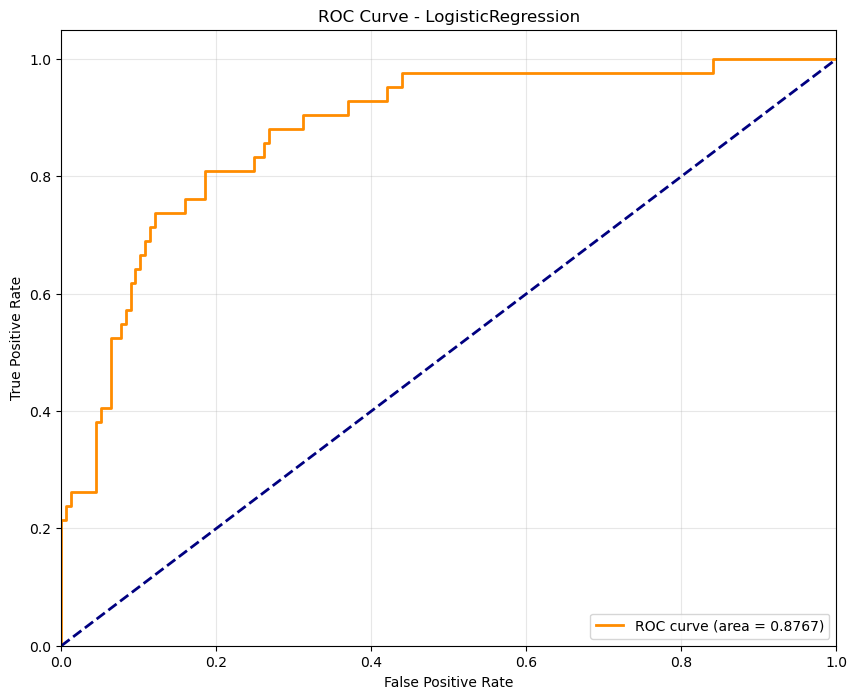

AUC-ROC: 0.8767


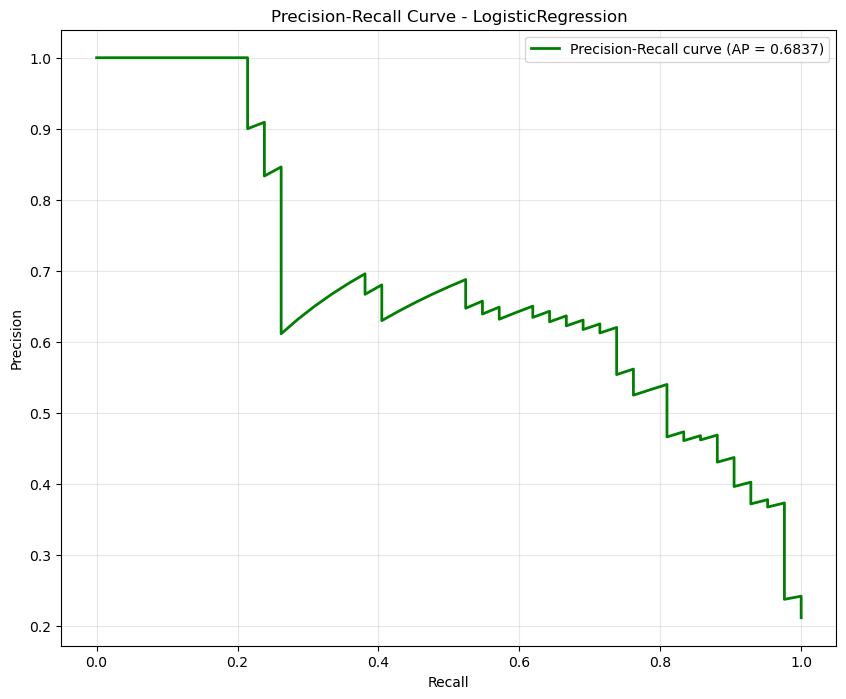

Average Precision: 0.6837


<Figure size 800x600 with 0 Axes>

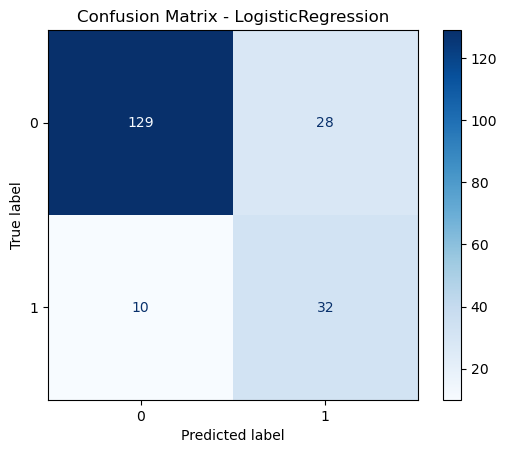


Confusion Matrix:
True Negatives: 129
False Positives: 28
False Negatives: 10
True Positives: 32

Calculating Permutation Feature Importance...


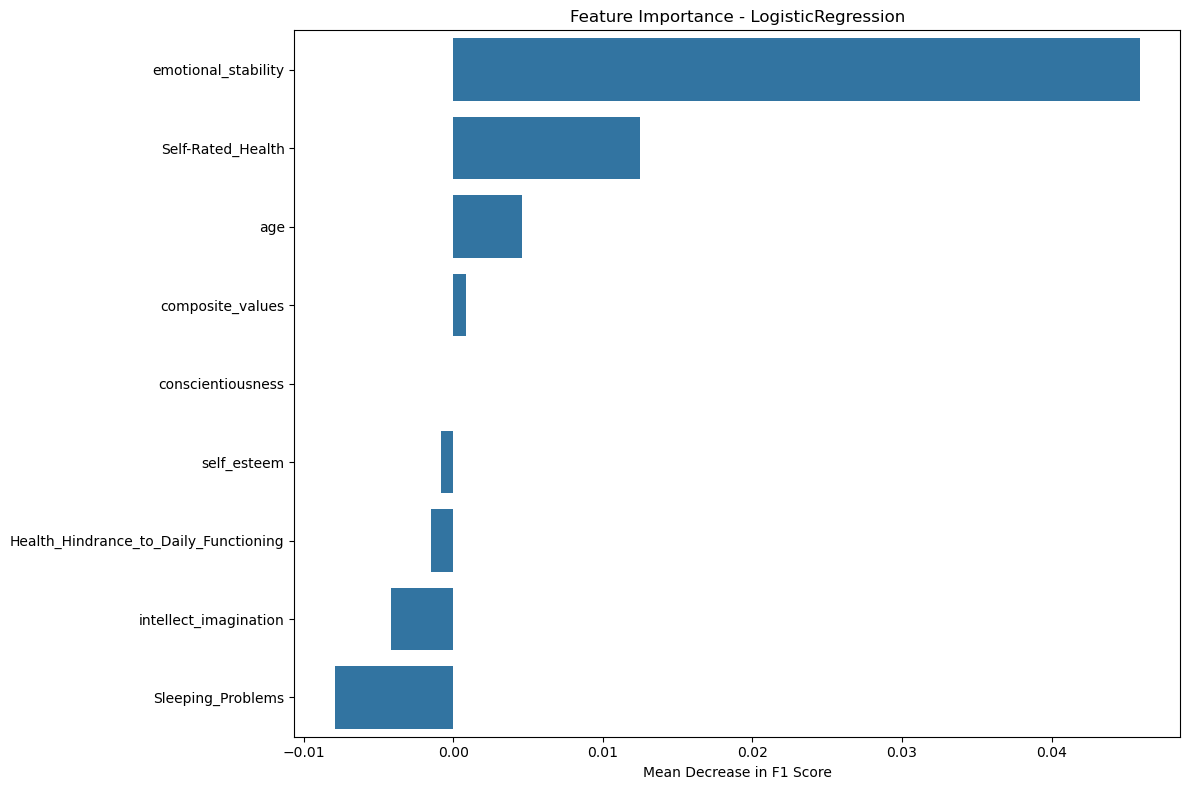


Top 10 Most Important Features:
emotional_stability: 0.0459 ± 0.0104
Self-Rated_Health: 0.0125 ± 0.0101
age: 0.0046 ± 0.0118
composite_values: 0.0009 ± 0.0017
conscientiousness: 0.0000 ± 0.0000
self_esteem: -0.0008 ± 0.0140
Health_Hindrance_to_Daily_Functioning: -0.0015 ± 0.0105
intellect_imagination: -0.0041 ± 0.0038
Sleeping_Problems: -0.0079 ± 0.0096


In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix, 
    ConfusionMatrixDisplay,
    roc_curve, 
    auc, 
    precision_recall_curve, 
    average_precision_score
)
from sklearn.inspection import permutation_importance

# We already have y_pred from the code above
# Get probabilities if the model supports it
if hasattr(best_estimator, "predict_proba"):
    y_proba = best_estimator.predict_proba(X_test)[:, 1]
    
    # === ROC Curve ===
    plt.figure(figsize=(10, 8))
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {best_model_name}')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.show()
    print(f"AUC-ROC: {roc_auc:.4f}")
    
    # === Precision-Recall Curve ===
    plt.figure(figsize=(10, 8))
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = average_precision_score(y_test, y_proba)
    plt.plot(recall, precision, color='green', lw=2, 
             label=f'Precision-Recall curve (AP = {pr_auc:.4f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {best_model_name}')
    plt.legend(loc="upper right")
    plt.grid(True, alpha=0.3)
    plt.show()
    print(f"Average Precision: {pr_auc:.4f}")
else:
    print(f"Note: {best_model_name} does not support probability predictions for ROC and PR curves")

# === Confusion Matrix ===
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title(f'Confusion Matrix - {best_model_name}')
plt.show()

# Print confusion matrix values
print("\nConfusion Matrix:")
print(f"True Negatives: {cm[0,0]}")
print(f"False Positives: {cm[0,1]}")
print(f"False Negatives: {cm[1,0]}")
print(f"True Positives: {cm[1,1]}")

# === Permutation Feature Importance ===
print("\nCalculating Permutation Feature Importance...")
result = permutation_importance(
    best_estimator, 
    X_test, 
    y_test, 
    scoring='f1_weighted', 
    n_repeats=10, 
    random_state=42, 
    n_jobs=-1
)

# Get feature names
feature_names = X_test.columns if hasattr(X_test, 'columns') else [f"Feature {i}" for i in range(X_test.shape[1])]

# Sort features by importance
sorted_idx = result.importances_mean.argsort()[::-1]

# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(
    x=result.importances_mean[sorted_idx], 
    y=[feature_names[i] for i in sorted_idx]
)
plt.title(f"Feature Importance - {best_model_name}")
plt.xlabel("Mean Decrease in F1 Score")
plt.tight_layout()
plt.show()

# Print top features with importance values
print("\nTop 10 Most Important Features:")
for i in sorted_idx[:10]:
    feature_name = feature_names[i]
    print(f"{feature_name}: {result.importances_mean[i]:.4f} ± {result.importances_std[i]:.4f}")

# ** Evaluate estimated best model on Test set 2023**

In [60]:
# Step 1: Import the 2023 data with MHI-5 outcomes
mhi_df_2023 = pd.read_csv(r"C:\Users\u1246538\Downloads\liss-data\Notebooks_MHI-5\merged_df_2023_cleaned_with_traits_and_values_cleaned_final_cleaned.csv")
mhi_df_2023.head()
print(mhi_df_2023.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 895 entries, 0 to 894
Data columns (total 39 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   nomem_encr             895 non-null    int64  
 1   ch22o162               895 non-null    object 
 2   uy22a016               895 non-null    object 
 3   uy22a015               895 non-null    object 
 4   cr22o143               895 non-null    float64
 5   cr22o144               895 non-null    object 
 6   cs22o439               895 non-null    object 
 7   cs22o487               895 non-null    object 
 8   cs22o280               895 non-null    object 
 9   cs22o436               895 non-null    object 
 10  cs22o472               895 non-null    object 
 11  cs22o473               895 non-null    object 
 12  cs22o474               895 non-null    object 
 13  cs22o577               895 non-null    object 
 14  cs22o578               895 non-null    object 
 15  cs22o5

In [62]:
# Step 2: Extract only the necessary columns using the actual column names
mhi_subset_2023 = mhi_df_2023[['nomem_encr', 'class', 'standardized_score']]

# Step 3: Rename columns to match our expected naming convention for consistency
mhi_subset_2023 = mhi_subset_2023.rename(columns={
    'class': 'MHI5_class_2023',
    'standardized_score': 'MHI5_std_score_2023'
})

mhi_subset_2023.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 895 entries, 0 to 894
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   nomem_encr           895 non-null    int64  
 1   MHI5_class_2023      895 non-null    int64  
 2   MHI5_std_score_2023  895 non-null    float64
dtypes: float64(1), int64(2)
memory usage: 21.1 KB


In [64]:
# Step 4: Merge with your original lasso dataframe
df_2023 = pd.read_csv(r'C:\Users\u1246538\Downloads\liss-data\Notebooks_MHI-5\selected_features_rf_with_id.csv')
merged_df_2023 = df_2023.merge(mhi_subset_2023, on='nomem_encr', how='left')

print("Merged 2023 Data Shape:", merged_df_2023.shape)
merged_df_2023.head()


Merged 2023 Data Shape: (995, 13)


,nomem_encr,emotional_stability,self_esteem,Self-Rated_Health,age,Health_Hindrance_to_Daily_Functioning,nomem_encr.1,Sleeping_Problems,conscientiousness,composite_values,intellect_imagination,MHI5_class_2023,MHI5_std_score_2023
0,800015,4.3,6.2,3,60.0,1.0,800015,0.0,4.4,5.750000,3.9,0.0,80.0
1,800100,2.7,5.2,2,32.0,3.0,800100,0.0,4.4,6.500000,3.4,0.0,80.0
2,800201,2.6,3.9,3,49.0,2.0,800201,0.0,3.8,4.638889,3.3,0.0,68.0
3,800228,4.1,5.8,3,70.0,2.0,800228,0.0,3.1,4.777778,3.3,0.0,80.0
4,800392,4.2,6.1,3,60.0,2.0,800392,0.0,3.2,4.833333,3.8,0.0,80.0


In [66]:
X_2023 = merged_df_2023.drop(columns= ['MHI5_class_2023', 'MHI5_std_score_2023', 'nomem_encr', 'nomem_encr.1'])
y_2023 = merged_df_2023['MHI5_class_2023']


print("X_2023 Shape:", X_2023.shape, X.info())
print('-------------------------')
print("y_2023 Shape:", y_2023.shape, y.info())

<class 'pandas.core.frame.DataFrame'>
Index: 994 entries, 0 to 994
Data columns (total 9 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   emotional_stability                    994 non-null    float64
 1   self_esteem                            994 non-null    float64
 2   Self-Rated_Health                      994 non-null    int64  
 3   age                                    994 non-null    float64
 4   Health_Hindrance_to_Daily_Functioning  994 non-null    float64
 5   Sleeping_Problems                      994 non-null    float64
 6   conscientiousness                      994 non-null    float64
 7   composite_values                       994 non-null    float64
 8   intellect_imagination                  994 non-null    float64
dtypes: float64(8), int64(1)
memory usage: 77.7 KB
X_2023 Shape: (995, 9) None
-------------------------
<class 'pandas.core.series.Series'>
Index: 994 e

In [68]:
# Reset indices
X_2023 = X_2023.reset_index(drop=True)
y_2023 = y_2023.reset_index(drop=True)

# Apply the same imputation strategy used for 2022 data
X_2023[columns_with_na] = imputer.transform(X_2023[columns_with_na])

# Ensure y_2023 is a Series, not a DataFrame
if isinstance(y_2023, pd.DataFrame):
    y_2023 = y_2023.squeeze()

# Drop NAN and align features
y_2023=y_2023.dropna()
X_2023 = X_2023.loc[y_2023.index]

#final check before split
print("NaNs in y_2023 before split:", y_2023.isna().sum())
print("NaNs in X_2023 before split:", X_2023.isna().sum())
print("y_2023 shape:", y_2023.shape)
print("X_2023 shape:", X_2023.shape)
print('--------------')
y_2023.info()
print('--------------')
print('--------------')
X_2023.info()

NaNs in y_2023 before split: 0
NaNs in X_2023 before split: emotional_stability                      0
self_esteem                              0
Self-Rated_Health                        0
age                                      0
Health_Hindrance_to_Daily_Functioning    0
Sleeping_Problems                        0
conscientiousness                        0
composite_values                         0
intellect_imagination                    0
dtype: int64
y_2023 shape: (895,)
X_2023 shape: (895, 9)
--------------
<class 'pandas.core.series.Series'>
Index: 895 entries, 0 to 993
Series name: MHI5_class_2023
Non-Null Count  Dtype  
--------------  -----  
895 non-null    float64
dtypes: float64(1)
memory usage: 14.0 KB
--------------
--------------
<class 'pandas.core.frame.DataFrame'>
Index: 895 entries, 0 to 993
Data columns (total 9 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   emot

In [70]:
# Split the 2023 data using the same approach as 2022
X_train_2023, X_test_2023, y_train_2023, y_test_2023 = train_test_split(
    X_2023, y_2023, test_size=0.2, random_state=42, stratify=y_2023
)

# NEW: Drop 'nomem_encr' from test set only bc you only evaluate on test set, no need of training set here
X_test_2023_clean = X_test_2023.drop(columns=["nomem_encr"], errors="ignore")

# Now you can use X_test_2023_clean safely for prediction:
y_pred_2023 = best_model.predict(X_test_2023_clean)
#Before train_test_split, you need nomem_encr for aligning the merge.
#After the split, you have X_train_2023 and X_test_2023.
#Only in X_test_2023, you drop 'nomem_encr' right before prediction.

In [72]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# You've already identified the best model from 2022
# best_model_name = max(models_info, key=lambda name: np.mean(models_info[name]['test_score']))
# best_model_cv = models_info[best_model_name]
# best_index = np.argmax(best_model_cv['test_score'])
# best_estimator = best_model_cv['estimator'][best_index]

# Drop ID column before predicting
X_test_2023_clean = X_test_2023

# Predict using the best model from 2022
y_pred_2023 = best_estimator.predict(X_test_2023_clean)

print(f"\n=== Evaluation of {best_model_name} on 2023 Test Set ===")
print(classification_report(y_test_2023, y_pred_2023))


=== Evaluation of LogisticRegression on 2023 Test Set ===
              precision    recall  f1-score   support

         0.0       0.94      0.81      0.87       144
         1.0       0.50      0.77      0.61        35

    accuracy                           0.80       179
   macro avg       0.72      0.79      0.74       179
weighted avg       0.85      0.80      0.82       179



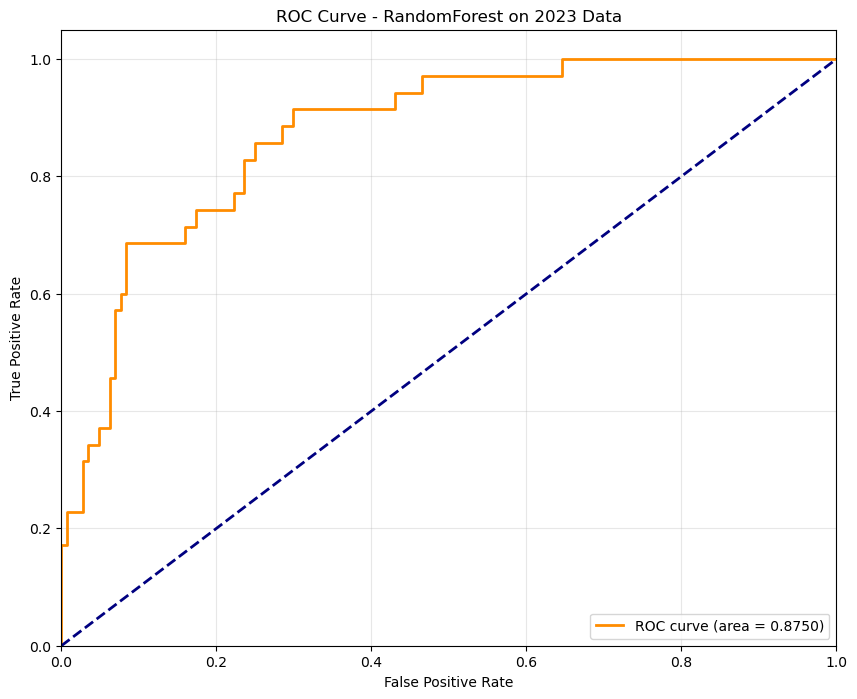

AUC-ROC (2023): 0.8750


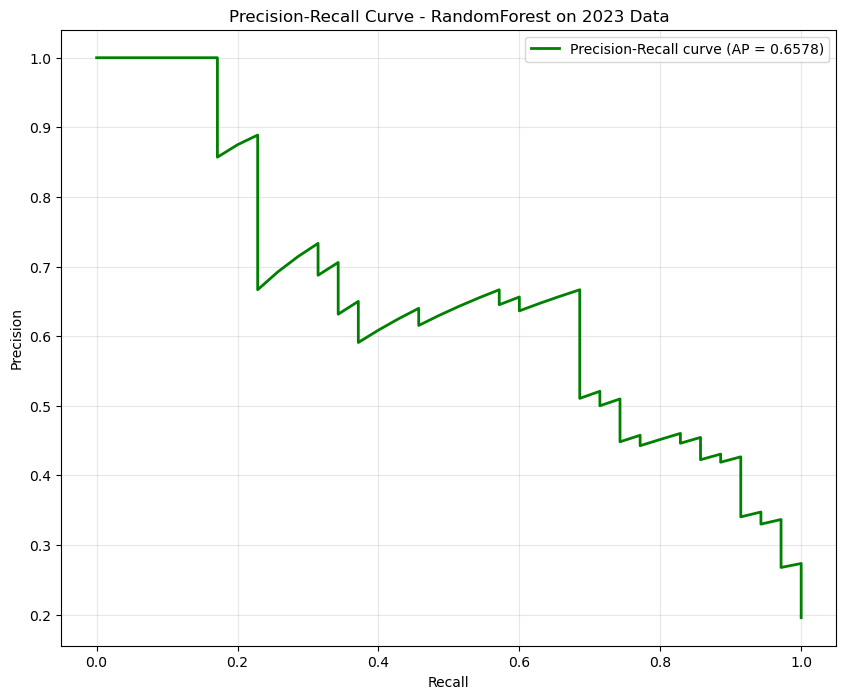

Average Precision (2023): 0.6578


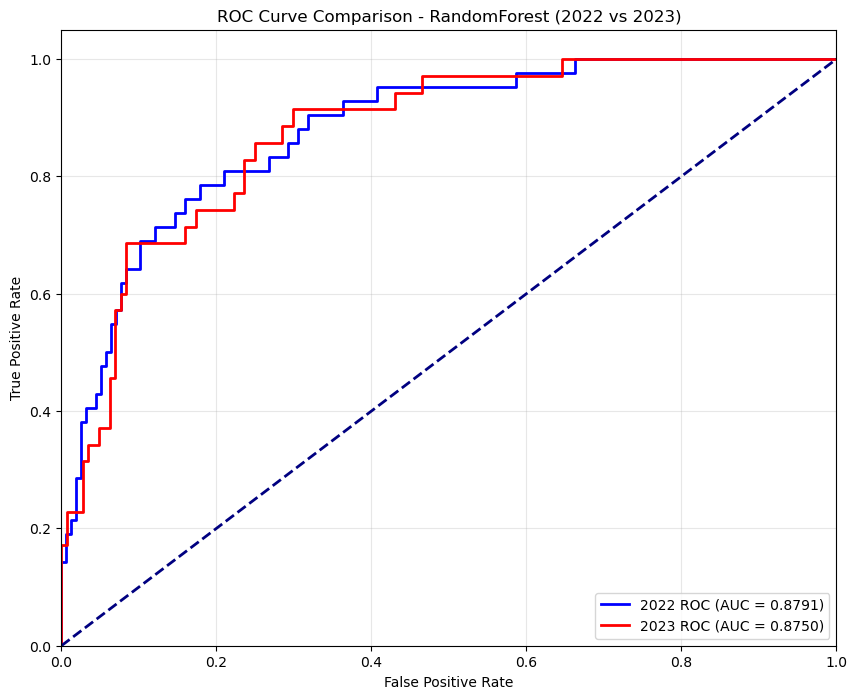

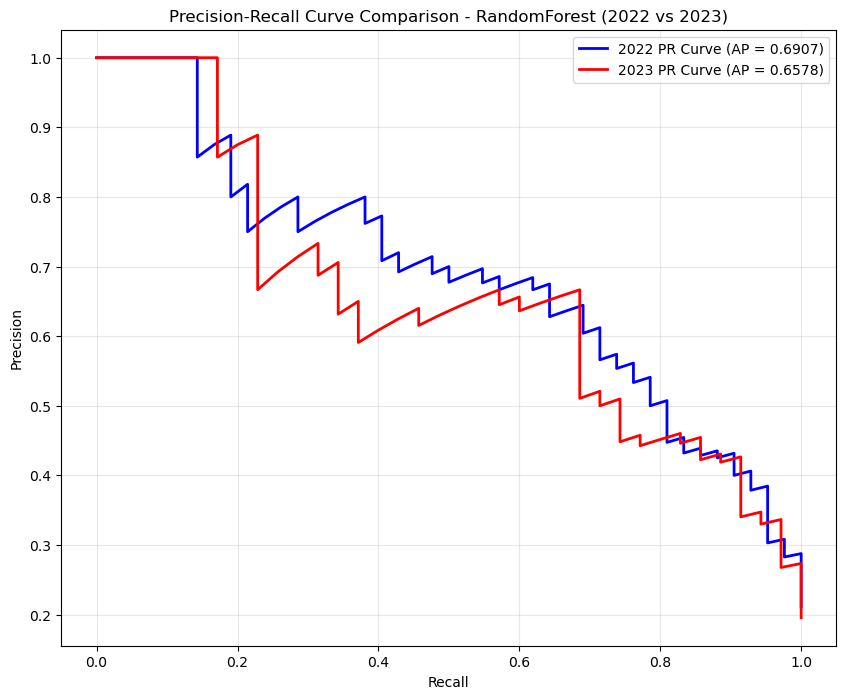

<Figure size 800x600 with 0 Axes>

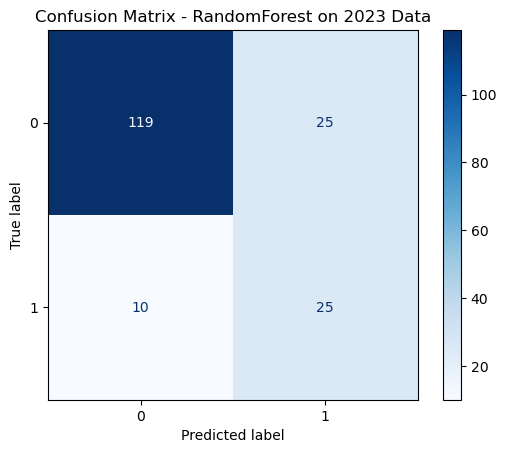


Confusion Matrix (2023):
True Negatives: 119
False Positives: 25
False Negatives: 10
True Positives: 25


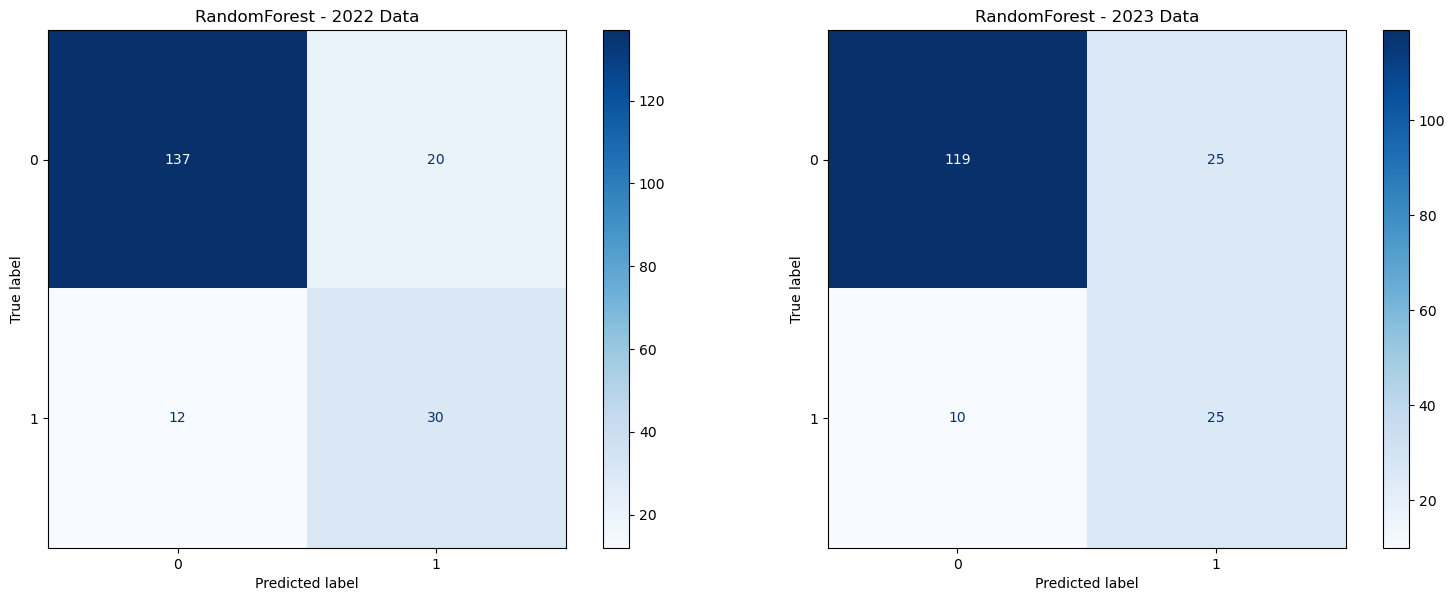


Calculating Permutation Feature Importance for 2023 data...


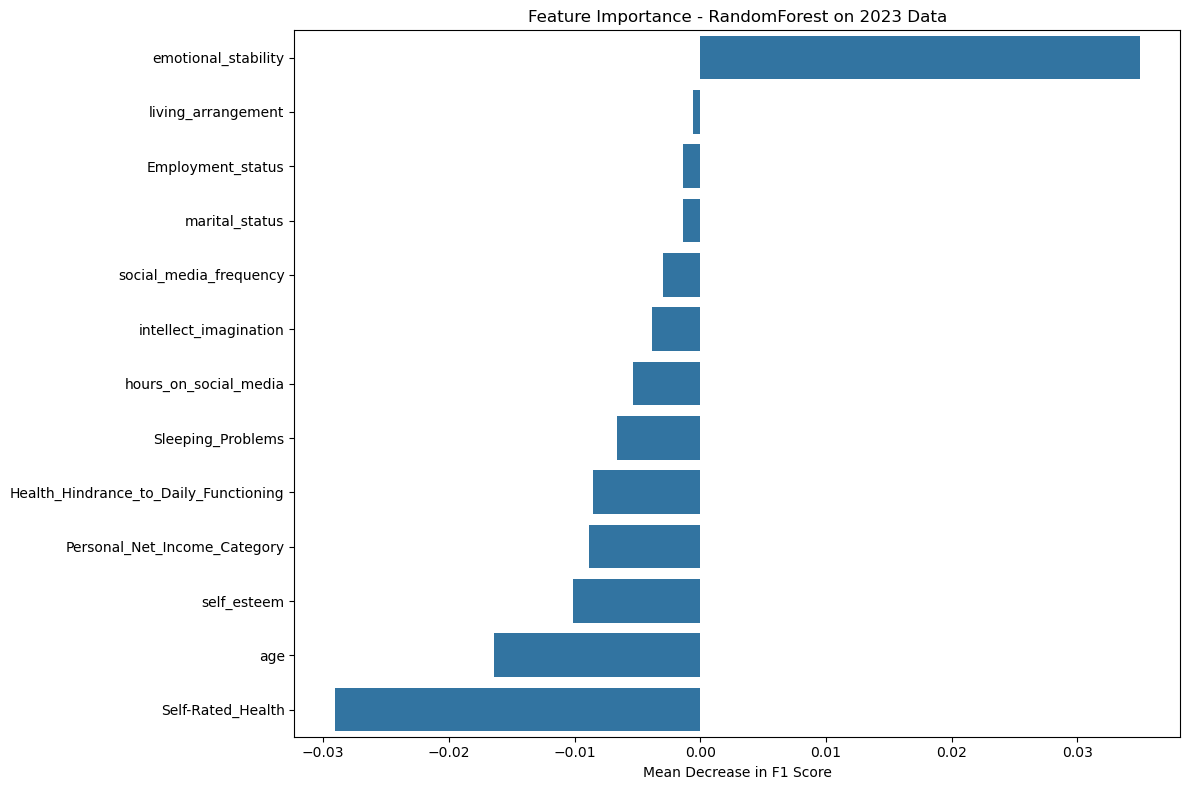


Top 10 Most Important Features (2023):
emotional_stability: 0.0350 ± 0.0179
living_arrangement: -0.0006 ± 0.0032
Employment_status: -0.0014 ± 0.0021
marital_status: -0.0014 ± 0.0021
social_media_frequency: -0.0029 ± 0.0059
intellect_imagination: -0.0039 ± 0.0064
hours_on_social_media: -0.0054 ± 0.0043
Sleeping_Problems: -0.0066 ± 0.0112
Health_Hindrance_to_Daily_Functioning: -0.0085 ± 0.0085
Personal_Net_Income_Category: -0.0089 ± 0.0046


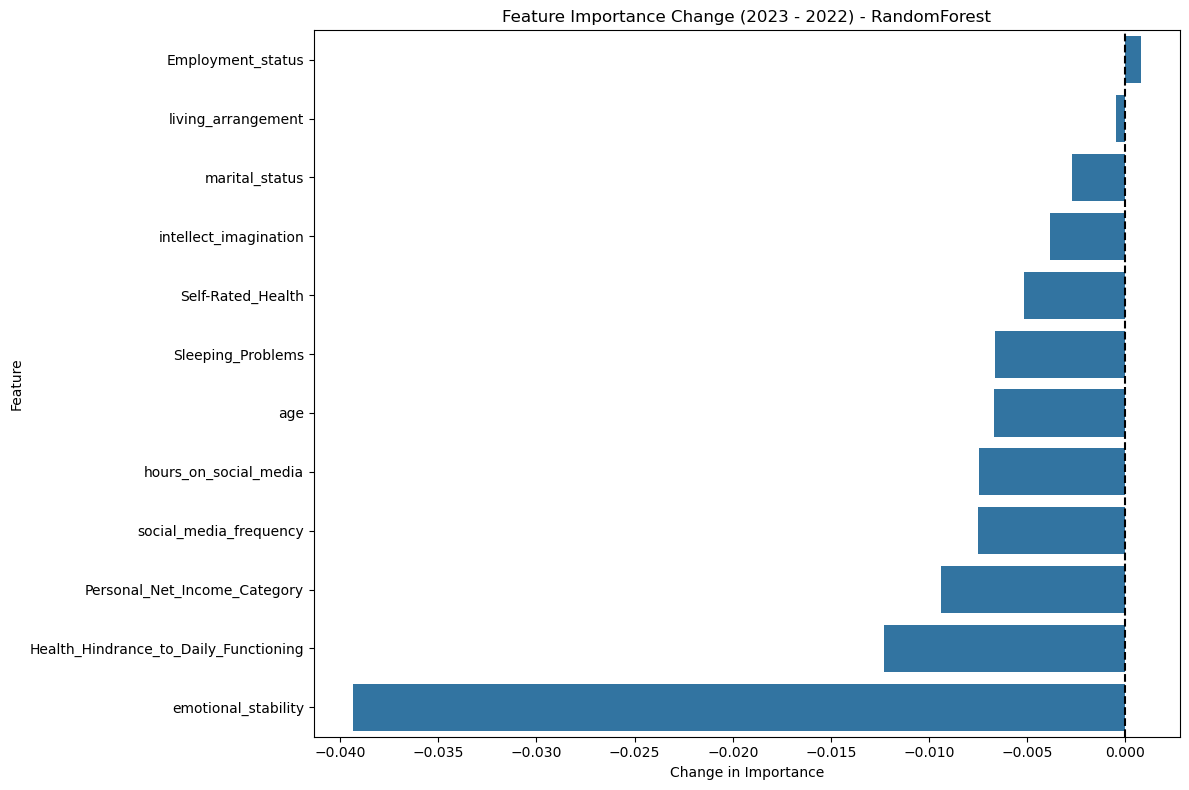


=== Performance Comparison Summary: 2022 vs 2023 ===
Metric            2022      2023    Change
------------------------------------------
Accuracy        0.8392    0.8045   -0.0347
F1 Score        0.8441    0.8164   -0.0277
Precision       0.8520    0.8399   -0.0122
Recall          0.8392    0.8045   -0.0347
AUC-ROC         0.8791    0.8750   -0.0041
Avg Prec        0.6907    0.6578   -0.0329


In [97]:
# Continue from previous code - Add these visualizations for 2023 data
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix, 
    ConfusionMatrixDisplay,
    roc_curve, 
    auc, 
    precision_recall_curve, 
    average_precision_score
)
from sklearn.inspection import permutation_importance

# We already predicted y_pred_2023 using best_estimator
# Get probabilities for 2023 data if the model supports it
if hasattr(best_estimator, "predict_proba"):
    y_proba_2023 = best_estimator.predict_proba(X_test_2023_clean)[:, 1]
    
    # === ROC Curve for 2023 ===
    plt.figure(figsize=(10, 8))
    fpr_2023, tpr_2023, _ = roc_curve(y_test_2023, y_proba_2023)
    roc_auc_2023 = auc(fpr_2023, tpr_2023)
    plt.plot(fpr_2023, tpr_2023, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_2023:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {best_model_name} on 2023 Data')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.show()
    print(f"AUC-ROC (2023): {roc_auc_2023:.4f}")
    
    # === Precision-Recall Curve for 2023 ===
    plt.figure(figsize=(10, 8))
    precision_2023, recall_2023, _ = precision_recall_curve(y_test_2023, y_proba_2023)
    pr_auc_2023 = average_precision_score(y_test_2023, y_proba_2023)
    plt.plot(recall_2023, precision_2023, color='green', lw=2, 
             label=f'Precision-Recall curve (AP = {pr_auc_2023:.4f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {best_model_name} on 2023 Data')
    plt.legend(loc="upper right")
    plt.grid(True, alpha=0.3)
    plt.show()
    print(f"Average Precision (2023): {pr_auc_2023:.4f}")
    
    # Compare 2022 vs 2023 ROC curves on one plot
    plt.figure(figsize=(10, 8))
    # Get 2022 ROC curve data (assuming you've already calculated this)
    fpr_2022, tpr_2022, _ = roc_curve(y_test, y_proba)
    roc_auc_2022 = auc(fpr_2022, tpr_2022)
    
    plt.plot(fpr_2022, tpr_2022, color='blue', lw=2, label=f'2022 ROC (AUC = {roc_auc_2022:.4f})')
    plt.plot(fpr_2023, tpr_2023, color='red', lw=2, label=f'2023 ROC (AUC = {roc_auc_2023:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve Comparison - {best_model_name} (2022 vs 2023)')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Compare 2022 vs 2023 Precision-Recall curves on one plot
    plt.figure(figsize=(10, 8))
    # Get 2022 PR curve data (assuming you've already calculated this)
    precision_2022, recall_2022, _ = precision_recall_curve(y_test, y_proba)
    pr_auc_2022 = average_precision_score(y_test, y_proba)
    
    plt.plot(recall_2022, precision_2022, color='blue', lw=2, label=f'2022 PR Curve (AP = {pr_auc_2022:.4f})')
    plt.plot(recall_2023, precision_2023, color='red', lw=2, label=f'2023 PR Curve (AP = {pr_auc_2023:.4f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve Comparison - {best_model_name} (2022 vs 2023)')
    plt.legend(loc="upper right")
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print(f"Note: {best_model_name} does not support probability predictions for ROC and PR curves")

# === Confusion Matrix for 2023 ===
plt.figure(figsize=(8, 6))
cm_2023 = confusion_matrix(y_test_2023, y_pred_2023)
disp_2023 = ConfusionMatrixDisplay(confusion_matrix=cm_2023)
disp_2023.plot(cmap='Blues')
plt.title(f'Confusion Matrix - {best_model_name} on 2023 Data')
plt.show()

# Print confusion matrix values
print("\nConfusion Matrix (2023):")
print(f"True Negatives: {cm_2023[0,0]}")
print(f"False Positives: {cm_2023[0,1]}")
print(f"False Negatives: {cm_2023[1,0]}")
print(f"True Positives: {cm_2023[1,1]}")

# Display 2022 vs 2023 confusion matrices side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
# 2022 CM
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp1.plot(ax=axes[0], cmap='Blues')
axes[0].set_title(f'{best_model_name} - 2022 Data')
# 2023 CM
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_2023, display_labels=[0, 1])
disp2.plot(ax=axes[1], cmap='Blues')
axes[1].set_title(f'{best_model_name} - 2023 Data')
plt.tight_layout()
plt.show()

# === Permutation Feature Importance for 2023 ===
print("\nCalculating Permutation Feature Importance for 2023 data...")
result_2023 = permutation_importance(
    best_estimator, 
    X_test_2023_clean, 
    y_test_2023, 
    scoring='f1_weighted', 
    n_repeats=10, 
    random_state=42, 
    n_jobs=-1
)

# Get feature names for 2023 data
feature_names_2023 = X_test_2023.columns if hasattr(X_test_2023, 'columns') else [f"Feature {i}" for i in range(X_test_2023.shape[1])]

# Sort features by importance
sorted_idx_2023 = result_2023.importances_mean.argsort()[::-1]

# Plot feature importance for 2023
plt.figure(figsize=(12, 8))
sns.barplot(
    x=result_2023.importances_mean[sorted_idx_2023], 
    y=[feature_names_2023[i] for i in sorted_idx_2023]
)
plt.title(f"Feature Importance - {best_model_name} on 2023 Data")
plt.xlabel("Mean Decrease in F1 Score")
plt.tight_layout()
plt.show()

# Print top features with importance values for 2023
print("\nTop 10 Most Important Features (2023):")
for i in sorted_idx_2023[:10]:
    feature_name = feature_names_2023[i]
    print(f"{feature_name}: {result_2023.importances_mean[i]:.4f} ± {result_2023.importances_std[i]:.4f}")

# Compare feature importances between 2022 and 2023
# Get top 10 features from both years
top_features_2022 = [feature_names[i] for i in sorted_idx[:10]]
top_importances_2022 = result.importances_mean[sorted_idx[:10]]

top_features_2023 = [feature_names_2023[i] for i in sorted_idx_2023[:10]]
top_importances_2023 = result_2023.importances_mean[sorted_idx_2023[:10]]

# Create a feature comparison dataframe
import pandas as pd
comparison_df = pd.DataFrame({
    'Feature': list(set(top_features_2022 + top_features_2023)),
})

# Add importances for 2022
for feature in comparison_df['Feature']:
    if feature in top_features_2022:
        idx = top_features_2022.index(feature)
        comparison_df.loc[comparison_df['Feature'] == feature, '2022_Importance'] = top_importances_2022[idx]
    else:
        comparison_df.loc[comparison_df['Feature'] == feature, '2022_Importance'] = 0

# Add importances for 2023
for feature in comparison_df['Feature']:
    if feature in top_features_2023:
        idx = top_features_2023.index(feature)
        comparison_df.loc[comparison_df['Feature'] == feature, '2023_Importance'] = top_importances_2023[idx]
    else:
        comparison_df.loc[comparison_df['Feature'] == feature, '2023_Importance'] = 0

# Calculate importance change
comparison_df['Change'] = comparison_df['2023_Importance'] - comparison_df['2022_Importance']
comparison_df = comparison_df.sort_values('Change', ascending=False)

# Plot feature importance change
plt.figure(figsize=(12, 8))
sns.barplot(
    x='Change',
    y='Feature',
    data=comparison_df
)
plt.title(f"Feature Importance Change (2023 - 2022) - {best_model_name}")
plt.xlabel("Change in Importance")
plt.axvline(x=0, color='black', linestyle='--')
plt.tight_layout()
plt.show()

# Print summary statistics comparing 2022 and 2023 performance
print("\n=== Performance Comparison Summary: 2022 vs 2023 ===")
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Calculate metrics for 2022
accuracy_2022 = accuracy_score(y_test, y_pred)
f1_2022 = f1_score(y_test, y_pred, average='weighted')
precision_2022 = precision_score(y_test, y_pred, average='weighted')
recall_2022 = recall_score(y_test, y_pred, average='weighted')

# Calculate metrics for 2023
accuracy_2023 = accuracy_score(y_test_2023, y_pred_2023)
f1_2023 = f1_score(y_test_2023, y_pred_2023, average='weighted')
precision_2023 = precision_score(y_test_2023, y_pred_2023, average='weighted')
recall_2023 = recall_score(y_test_2023, y_pred_2023, average='weighted')

# Print comparison table
print(f"{'Metric':<12}{'2022':>10}{'2023':>10}{'Change':>10}")
print(f"{'-'*42}")
print(f"{'Accuracy':<12}{accuracy_2022:>10.4f}{accuracy_2023:>10.4f}{accuracy_2023-accuracy_2022:>10.4f}")
print(f"{'F1 Score':<12}{f1_2022:>10.4f}{f1_2023:>10.4f}{f1_2023-f1_2022:>10.4f}")
print(f"{'Precision':<12}{precision_2022:>10.4f}{precision_2023:>10.4f}{precision_2023-precision_2022:>10.4f}")
print(f"{'Recall':<12}{recall_2022:>10.4f}{recall_2023:>10.4f}{recall_2023-recall_2022:>10.4f}")
if 'roc_auc_2022' in locals() and 'roc_auc_2023' in locals():
    print(f"{'AUC-ROC':<12}{roc_auc_2022:>10.4f}{roc_auc_2023:>10.4f}{roc_auc_2023-roc_auc_2022:>10.4f}")
if 'pr_auc_2022' in locals() and 'pr_auc_2023' in locals():
    print(f"{'Avg Prec':<12}{pr_auc_2022:>10.4f}{pr_auc_2023:>10.4f}{pr_auc_2023-pr_auc_2022:>10.4f}")